Train on MNIST. Adapted from Keras' convolutional MNIST example.

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1337)  # for reproducibility

from scipy.misc import imresize

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils

from seya.layers.attention import SpatialTransformer, ST2

batch_size = 128
nb_classes = 10
nb_epoch = 12

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [3]:
def augment_dataset(X):
    # Xnew = np.random.binomial(1, .8, (X.shape[0], 1, 56, 56)) * 0
    Xnew = np.zeros((X.shape[0], 56, 56))
    for i, x in enumerate(X):
        u1 = np.random.randint(0, 56-28, 1)
        u2 = ul = np.random.randint(0, 56-28, 1)
        Xnew[i, u1:u1+28, u2:u2+28] = x
    Xnew =  Xnew #+ .5 * np.random.binomial(1, .8, (X.shape[0], 56, 56)) 
    Xfinal = np.vstack([imresize(x, (28,28))[np.newaxis] for x in Xnew])
    return Xfinal[:, np.newaxis, :, :]

In [4]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
b[0, 1] = 1
W = np.zeros((784, 6), dtype='float32')
weights = [W, b.flatten()]

In [5]:
locnet = Sequential()
locnet.add(Convolution2D(1, 1, 1, 1))
locnet.add(Activation('relu'))
locnet.add(Flatten())
locnet.add(Dense(784, 6, weights=weights))

In [7]:
model = Sequential()

model.add(ST2(localization_net=locnet, downsample_factor=(1,1)))
model.add(Convolution2D(32, 1, 3, 3, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(32, 32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(2, 2)))

model.add(Flatten())
model.add(Dense(32*196, 128))
model.add(Activation('relu'))

model.add(Dense(128, nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

TypeError: int() argument must be a string or a number, not 'TensorVariable'

In [ ]:
nb_epochs = 50
batch_size = 128
for e in range(nb_epochs):
    print('-'*40)
    print('Epoch', e)
    print('-'*40)
    print("Training...")
    progbar = generic_utils.Progbar(X_train.shape[0])
    for b in range(X_train.shape[0]/batch_size):
        f = b * batch_size
        l = (b+1) * batch_size
        X_batch = augment_dataset(X_train[f:l])
        Y_batch = Y_train[f:l]
        loss = model.train_on_batch(X_batch, Y_batch)
        progbar.add(X_batch.shape[0], values=[("train loss", loss)])
    print('')



----------------------------------------
Epoch 0
----------------------------------------
Training...
59904/60000 [============================>.] - ETA: 0s - train loss: 0.2083
----------------------------------------
Epoch 1
----------------------------------------
Training...
59904/60000 [============================>.] - ETA: 0s - train loss: 0.1786
----------------------------------------
Epoch 2
----------------------------------------
Training...
59904/60000 [============================>.] - ETA: 0s - train loss: 0.1701
----------------------------------------
Epoch 3
----------------------------------------
Training...
15104/60000 [======>.......................] - ETA: 18s - train loss: 0.1667

### Visualizing what the Spatial Transformed learned

In [199]:
import theano
XX = model.get_input()
YY = model.layers[0].get_output()
F = theano.function([XX], YY)

In [200]:
Xaug = augment_dataset(X_train[:9])
Xresult = F(Xaug.astype('float32'))

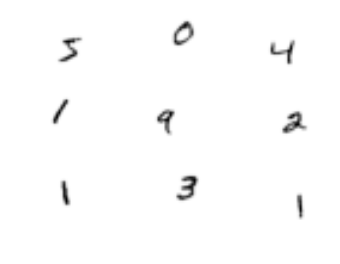

In [201]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xaug[i, 0])
    plt.axis('off')

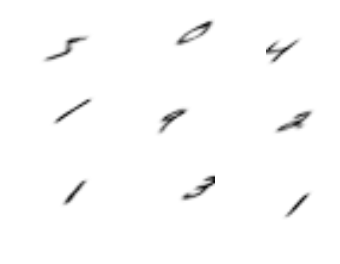

In [202]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xresult[i, 0])
    plt.axis('off')